# Optimisation of Storage with dynamic programming
### Table of Contents

* [1. Simple examples of how to use the dynamic programming tool ](#1.introduction)
    * [1.1 First basic problem](#1.1.Simple1)
    * [1.2 With storage efficiency  ](#1.1.Simple2)
    * [1.3 With real market data](#1.3.Real)
* [2. Case of two storages ](#2.two)
    * [2.1 Exercice - 1 two storage with perfect efficiency ](#2.1.two)
    * [2.2 Exercice - 2 with efficiency -](#2.2.two)
    * [2.3 Computation](#2.3.two)


In [10]:
#region importation of modules
import os
if os.path.basename(os.getcwd())=="BasicFunctionalities":
    os.chdir('..') ## to work at project root  like in any IDE

import numpy as np
import pandas as pd
import csv

import datetime
import copy
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn import linear_model
import sys
import mosek


from dynprogstorage.Wrapper_dynprogstorage import Pycplfunction, Pycplfunctionvec
from dynprogstorage.wrappers import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functions.f_operationModels import *
from functions.f_optimization import *
from functions.f_graphicalTools import *
from dynprogstorage.wrappers import GenCostFunctionFromMarketPrices
from numpy import random
import time
#endregion
InputFolder='Data/input/'


# 1 . Simple examples of how to use the dynamic programming tool  <a class="anchor" id="1.simple"></a>
## 1.1 Simplest operation example  <a class="anchor" id="1.1.Simple1"></a>
We solve the following optimisation problem
$
\begin{align}
\min \;\;\;\;\;\;\;\;\;\; & \sum_{i=1}^n \phi_i(x_i) \\
 -p_{\max} \leq x_i\leq p_{\max} & \;\; \forall i=1,\dots,n \\
 0 \leq\sum_{j=1}^i x_j \leq c_{\max} & \;\;  \forall i=1,\dots,n
\end{align}
$

$x_i>0$ : is a consumption from the network
$x_i<0$ : is a production to the network
$\phi_i(x_i)$ is a cost of buying/selling that has to be minimized.
In the model below the cost is simply

$$\phi_i(x_i)=\pi_i\xi_i$$

with $\pi_i$ the market price at time $i$.

[1.0, 1.0, 1.0, 1.0, -1.0, -1.0, 1.0, 1.0, 1.0, 1.0, -1.0, 1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0, 1.0, 1.0, -1.0, 1.0, 1.0, -1.0, -1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, 1.0, 1.0, -1.0, 1.0, 1.0, 1.0, 1.0, -1.0, 1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, 1.0, 1.0, -1.0, -1.0, -1.0, 1.0, -1.0, 1.0, 1.0, -1.0, 0.0, -1.0, -1.0, 1.0, 1.0, 1.0, 1.0, -1.0, 1.0, 1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, 1.0, -1.0, 1.0, 1.0, 1.0, -1.0, 1.0, 1.0, -1.0, 1.0, -1.0, -1.0, -1.0, 1.0, 1.0, -1.0, 1.0, 1.0, 0.0, -1.0, 1.0, -1.0, 1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, 1.0, -1.0, 1.0, 1.0, 1.0, -1.0, 1.0, -1.0, -1.0, 1.0, -1.0, 1.0, 1.0, 1.0, -1.0, 1.0, -1.0, -1.0, 1.0, 1.0, 1.0, 1.0, -1.0, -1.0, 1.0, 1.0, -1.0, -1.0, 1.0, -1.0, 1.0, -1.0, -1.0, 1.0, -1.0, -1.0, 1.0, 1.0, -1.0, 1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, 1.0, -1.0, 1.0, -1.0, -1.0, 1.0, 1.0, -1.0, 1

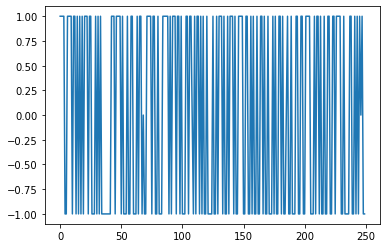

In [11]:
nbTime=250 ## n
Prices=random.uniform(1, 1000, nbTime)
p_max=1.
c_max=10.*p_max

## creation of nbTime cost functions
cpl_func = GenCostFunctionFromMarketPrices(Prices.tolist())
res = cpl_func.OptimMargInt([-p_max]*nbTime,[p_max]*nbTime,[0]*nbTime,[c_max]*nbTime)
print(res)

plt.plot(res)
plt.show()

## 1.2 With storage efficiency  <a class="anchor" id="1.1.Simple2"></a>

If one need to take into account the storage efficiency $\eta_{in}$ when
consuming and the storage efficiency $\eta_{out}$ when producing,
and the initial energy in the storage $E_0$ at time step $0$,
the problem becomes

$
\begin{align}
\min \;\;\;\;\;\;\;\;\;\; & \sum_{i=1}^n \psi_i(x_i) \\
 -p_{\max}/\eta_{out} \leq x_i\leq p_{\max}\eta_{in} & \;\; \forall i=1,\dots,n \\
 0 \leq E_0 + \sum_{j=1}^i x_j \leq c_{\max} & \;\;  \forall i=1,\dots,n
\end{align}
$

with $\psi_i$ the convex piecewise linear function given by :
$$ \psi_i(x)=\pi_ix_i \eta_{out} 1(x_i<0)+ \pi_i x_i/\eta_{in} 1(x_i>0)$$

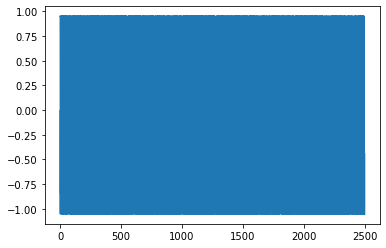

In [12]:
nbTime=2500
Prices=np.random.uniform(1, 1000, nbTime)
p_max=1.;  c_max=10.*p_max;
r_in = 0.95; ## rendement d'entrée
r_out=0.95 ## rendement de sortie
E_0 = 0. ## Energie initialement dans le stockage

CostFunction=GenCostFunctionFromMarketPrices(Prices,r_in=r_in,r_out=r_out)
res=CostFunction.OptimMargInt([-p_max/r_out]*nbTime,[p_max*r_in]*nbTime,[E_0]*nbTime,[c_max-E_0]*nbTime)
## p_max est la puissance maximal consommée ou injectée sur le réseau par le stockage

plt.plot(res) ### positive : energy consumed from the network. Negative : energy delivered to the network
plt.show()

## 1.3 With real market data <a class="anchor" id="1.3.Real"></a>

In [13]:
#region With real market data
Prices_df=pd.read_csv(InputFolder+'EuropeanMarket_Prices_UTC_2007_2017.csv',sep=',',decimal='.',skiprows=0)
year = 2012

PricesYear_df=Prices_df[pd.to_datetime(Prices_df['Dates']).dt.year==year]
PricesYear_df=PricesYear_df.reset_index()
nbTime=PricesYear_df.__len__()
if sum(PricesYear_df['Prices']<=0)>0 : PricesYear_df[PricesYear_df['Prices']<=0]=0.000001
p_max=1.;  c_max=10.*p_max;
r_in = 0.95; ## rendement d'entrée
r_out=0.95 ## rendement de sortie
CostFunction=GenCostFunctionFromMarketPrices(PricesYear_df.Prices.to_list(),r_in=r_in,r_out=r_out)
res=CostFunction.OptimMargInt([-p_max/r_out]*nbTime,[p_max*r_in]*nbTime,[0]*nbTime,[c_max]*nbTime)
Operation=pd.DataFrame(res, columns=["Operation"])
PricesYear_df=pd.concat([PricesYear_df,Operation],axis=1)
PricesYear_df['Revenu']= -PricesYear_df['Prices']*PricesYear_df['Operation']
PricesYear_df['Revenu'].sum() ## Revenu €/an pour 10 x 1MWh de batterie -- Coût 100 €/kWh 100 000 €/MWh
#Evolution entre 2007 et 2016 ?
#endregion



82644.30554839472

# 2. Case of two storages <a class="anchor" id="2.two"></a>
idée à développer (qui sera utile pour le cas de deux stockages) :
on doit pouvoir optimiser comme si il n'y avait pas de rendement
puis il faut faire une fonction qui rejete les échanges "non rentables" avec rendement
c'est à dire les block achat/vente avec Prix[achat]/r_in>Prix[vente]*r_out
cela demaderait de contruire (en c++) une map() f qui a chaque pas de temps t associe la map g
qui contient tous les block achetés présents dans le stockage par ordre décroissant de prix d'achat
g(prix)= pair(Energie,t) où t est le temps d'achat


## 2.1 Exercice - 1 two storage with perfect efficiency <a class="anchor" id="2.1.two"></a>
drawn the set
 $$ V(E,C) = { x1,x2 :  -E <= x1 <= C-E ; -E <= x1+x2 <= C-E }$$
and show that $V(E1,C1)+V(E2,C2)=V(E1+E1,C1+C2)$
## 2.2 Exercice - 2 with efficiency <a class="anchor" id="2.2.two"></a>
(To verify, I did this a bit quickly)
draw the set
$
\begin{align}
\{ x1,x2 & :\\
-E <= & x1*(x1<0)*r_{out} + x1*(x1>0)/r_{in} & <= C-E\\
-E <= & x1*(x1<0)*r_{out} + x1*(x1>0)/r_{in} +  x2*(x2<0)*r_{out} + x2*(x2>0)/r_{in} & <= C-E
\end{align}
$
 montrer que cet ensemble est V(Ebis,Cbis) avec Ebis et Cbis bien choisis

$Cbis-Ebis=(C-E0)*r_in$


$Cbis=(C-E0)*r_in+E0$

 note supplémentaire
 Si W(-P1,P2)={x : -P1 <= x<=P2} alors {x : -P <= x*(x<0)*r_out + x*(x>0)/r_in<= P}= W(-P/r_out,P*r_in)


## 2.3 Computation <a class="anchor" id="2.3.two"></a>

In [14]:
## Application_1
nbTime=10
Prices=np.random.uniform(1, 1000, nbTime)
p_max=1.;  c_max=10.*p_max;
E_0 = 0. ; r_in = 0.95; r_out=0.95
E_0Bis=E_0/r_out
c_maxBis = (c_max-E_0)*r_in + E_0Bis
CostFunction1=GenCostFunctionFromMarketPrices(Prices,r_in=1.,r_out=1.)
CostFunction2=GenCostFunctionFromMarketPrices(Prices,r_in=0.95,r_out=0.95 )
res1=CostFunction1.OptimMargInt([-p_max]*nbTime,[p_max]*nbTime,[E_0Bis]*nbTime,[c_maxBis-E_0Bis]*nbTime)
res2=CostFunction2.OptimMargInt([-p_max/r_out]*nbTime,[p_max*r_in]*nbTime,[E_0]*nbTime,[c_max-E_0]*nbTime)
numpy.array(res1)
numpy.array(res2)
for i in range(len(res1)):
    if (res1[i]>0) : res1[i]=res1[i]*r_in
    else : res1[i]=res1[i]/r_out
max(abs(numpy.array(res1)-numpy.array(res2)))
### pas pareil, il faudra supprimer les échanges "non rentables"

##### two storages with perfect efficiency
## note :  si l'étape d'avant a marché il faudrait faire le cas de deux stockages "avec rendement"
##### peut-etre plus compliqué
r_in1 = 1.; r_in2 = 1.;  ## rendement d'entrée
r_out1=1.; r_out2=1. ## rendement de sortie

r_in=1. ; r_out=1.
p_max1=10.;  c_max1=10.*p_max1;
p_max2=1.;  c_max2=1000.*p_max2;
E_01=0; E_02 =0 ;
p_max=p_max1+p_max2; c_max=c_max1+c_max2; E_0=E_01+E_02;

nbTime=500
Prices=np.random.uniform(1, 1000, nbTime)
#on resoud d'abord un stockage "somme"
CostFunction=GenCostFunctionFromMarketPrices(Prices,r_in=r_in,r_out=r_out)
res=CostFunction.OptimMargInt([-p_max/r_out]*nbTime,[p_max*r_in]*nbTime,[E_0]*nbTime,[c_max-E_0]*nbTime)

### a partir de la somme z=x+y on déduit x
### il suffit de trouve une solution x faisable telle que
### (1) x satisfait les contraintes du premier stockage
### (2) y satisfait les contraintes du second stockage
### (3) x+y = z
### on peut trouver çà en prenant une fonction coût constante égale à zéro et en choisissant bien les contraintes
CostFunction0=GenCostFunctionFromMarketPrices([0]*nbTime,r_in=1.,r_out=1.)

P1plus=numpy.array([p_max1*r_in1]*nbTime); P1moins=numpy.array([-p_max1/r_out1]*nbTime);
P2plus=numpy.array([p_max2*r_in2]*nbTime); P2moins=numpy.array([-p_max2/r_out2]*nbTime);
C1plus=numpy.array([c_max1-E_01]*nbTime); C1moins=numpy.array([-E_01]*nbTime);
C2plus=numpy.array([c_max2-E_02]*nbTime); C2moins=numpy.array([-E_02]*nbTime);
zz=numpy.array(res)
intzz=zz.cumsum()
lbP = pmax(P1moins,zz-P2plus); ubP = pmin(P1plus,zz-P2moins)
lbC = pmax(C1moins,intzz-C2plus); ubC = pmin(C1plus,intzz-C2moins)
min(numpy.array(ubP)-numpy.array(lbP))
min(numpy.array(ubC)-numpy.array(lbC))

res1=CostFunction0.OptimMargInt(lbP,ubP,lbC,ubC)
res2=zz-numpy.array(res1)


#pmin(x,y)






#### Annexe à développer,
####
#### Quelques exemples de base pour apprendre à utiliser les fondements de dynprogstorage.linearfunc l'outil de programmation dynamique
